In [1]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf
from scipy import stats

In [2]:
data_id = 0
data_conditions = ['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_mid']
obj = pickle.load(open('/media/data_cifs/afengler/data/real/cnn_results/results_bg_stn_sample_' + str(data_id) + '.pickle','rb'), 
                  encoding = 'latin1')
posterior_samples = pd.DataFrame(obj['final_x'], columns = ['v', 'a', 'w', 'ndt', 'theta'])

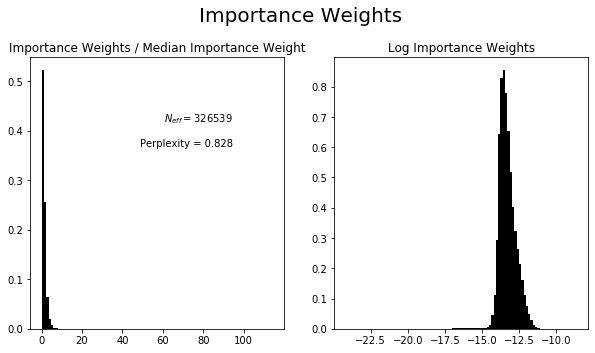

In [8]:
# Plot Weights and effective sample size:

# Calculate quantities of interest
effective_sample_size = 1 / np.sum(np.square(obj['final_w']))
perplexity = np.exp( - np.sum(obj['final_w'] * np.log(obj['final_w']))) / obj['final_w'].shape[0]
log_w = np.log(obj['final_w'])

fig, ax = plt.subplots(1, 2, 
                       figsize = (10, 5), 
                       sharex = False, 
                       sharey = False)
my_suptitle = fig.suptitle('Importance Weights', fontsize = 20, y = 1.02)

# Plot 
ax[0].hist(obj['final_w'] / np.median(obj['final_w']),
         bins = 100, 
         density = True,
         color = 'black')
ax[0].set_title('Importance Weights / Median Importance Weight')
ax[0].text(0.8, 
         0.8, 
         r"$N_{eff} = $" + str(int(effective_sample_size)),
         horizontalalignment = 'right',
         verticalalignment = 'top',
         rotation = 0,
         clip_on = False, 
         transform = ax[0].transAxes)
ax[0].text(0.8,
           0.7, 
         r"Perplexity = " + str(round(perplexity, 3)),
         horizontalalignment = 'right',
         verticalalignment = 'top',
         rotation = 0,
         clip_on = False,
         transform = ax[0].transAxes)

ax[1].hist(log_w, bins = 100, density = True, color = 'black')
ax[1].set_title('Log Importance Weights')


plt.savefig(os.getcwd() + '/figures/' + 'bg_stn_cnn_importance_weights.png', 
            dpi = 150, 
            transparent = False,
            bbox_inches = 'tight',
            bbox_extra_artists = [my_suptitle])
# Show
plt.show()

In [3]:
# Plot Post
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    ax.set_axis_off()
    font_size = (abs(corr_r) * 20) + 5
    
    marker_size = abs(corr_r) * 7000
    ax.scatter([.5], [.5], 
               marker_size, 
               [corr_r], 
               alpha = 0.6, 
               marker = 'o',
               cmap = "coolwarm",
               vmin = -1, 
               vmax = 1, 
               transform = ax.transAxes)
    
    ax.annotate(corr_text, [.5, .5,],  
                xycoords = "axes fraction",
                ha = 'center', 
                va = 'center', 
                fontsize = font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy = (0.6, 0.6), xycoords = ax.transAxes,
                color = 'black', fontsize = 20)

def make_posterior_pair_grid(posterior_samples = [],
                             height = 8,
                             aspect = 1,
                             n_subsample = 1000,
                             title = "BG-STN (Convnet)",
                             data_signature = '',
                             save = True):
    
    g = sns.PairGrid(posterior_samples.sample(n = 100), 
                     height = height / len(list(posterior_samples.keys())),
                     aspect = 1,
                     diag_sharey = False)
    g = g.map_diag(sns.kdeplot, color = 'black', shade = True) # shade = True, 
    g = g.map_lower(sns.kdeplot, 
                    shade_lowest = False, 
                    shade = True, 
                    cmap = 'Greys')
    g = g.map_lower(sns.regplot,
                    color = 'grey',
                    lowess = True,
                    x_ci = None,
                    marker = None,
                    scatter = False,
                    line_kws = {'alpha': 0.5})
    g = g.map_upper(corrdot)
    g = g.map_upper(corrfunc)
    
    [plt.setp(ax.get_xticklabels(), rotation = 45) for ax in g.axes.flat]
    my_suptitle = g.fig.suptitle(title + data_signature, y = 1.03, fontsize = 20)
    if save == True:
        plt.savefig(os.getcwd() + '/figures/' + 'bg_stn_cnn_pairwise_correlations_level_lines_posterior_' + data_signature + '.png', 
                    dpi = 150, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    # Show
    return plt.show()

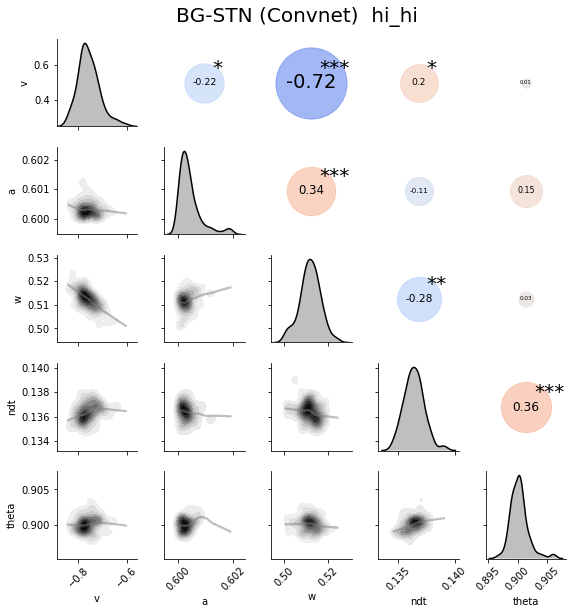

In [4]:
make_posterior_pair_grid(posterior_samples = posterior_samples,
                         height = 8,
                         aspect = 1,
                         n_subsample = 1000,
                         title = "BG-STN (Convnet)  ",
                         data_signature = data_conditions[data_id],
                         save = True)

In [21]:
# Posterior means
file_list = glob.glob('/media/data_cifs/afengler/data/real/cnn_results/results_bg_stn_sample*')

# Correct order of files
file_list = [file_list[i] for i in [2, 4, 1, 0, 3]]
posterior_samples_arr = np.array([pickle.load(open(file_,'rb'), encoding = 'latin1')['posterior_samples'] for file_ in file_list])

# TEMPORARY
posterior_samples_arr[:, 0, :] = - posterior_samples_arr[:, 0, :]
posteior_samples_arr[:, 2, :] = (1 - posterior_samples_arr[:, 2, :])

NameError: name 'posteior_samples_arr' is not defined

In [69]:
def bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'theta'], 
                       title = 'BG-STN: PARAMETER RECOVERY ANGLE',
                       x_labels = [],
                       data = [],
                       cols = 3):
    # Subsample data
    data = data[:, np.random.choice(data.shape[1], size = 1000), :]
    
    # Comute necessary number of rows
    rows = int(np.ceil(len(ax_titles) / cols))
    
    # Set styling parameters
    sns.set(style = "whitegrid", 
            palette = "muted", 
            color_codes = True)
    
    # Set up subplot grid
    fig, ax = plt.subplots(rows, cols, 
                           figsize = (8, 8), 
                           sharex = False, 
                           sharey = False)
    
    # Main plot
    for i in range(data.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        sns.violinplot(data = data[:, :, i].T,
                       ax = ax[row_tmp, col_tmp])
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 20)
        ax[row_tmp, col_tmp].set_xticklabels(x_labels, size = 14, rotation = 45)
    
    # Erase unused grids
    for i in range(data.shape[2], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    # Make layout tight and shrink box to accomodate global title
    my_suptitle = fig.suptitle(title, fontsize = 20)
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
    # Save figure
    plt.savefig(os.getcwd() + '/figures/' + 'bg_stn_cnn_parameter_posteriors_across_datasets.png', 
            dpi = 150, 
            transparent = False,
            bbox_inches = 'tight',
            bbox_extra_artists = [my_suptitle])
    
    return plt.show()

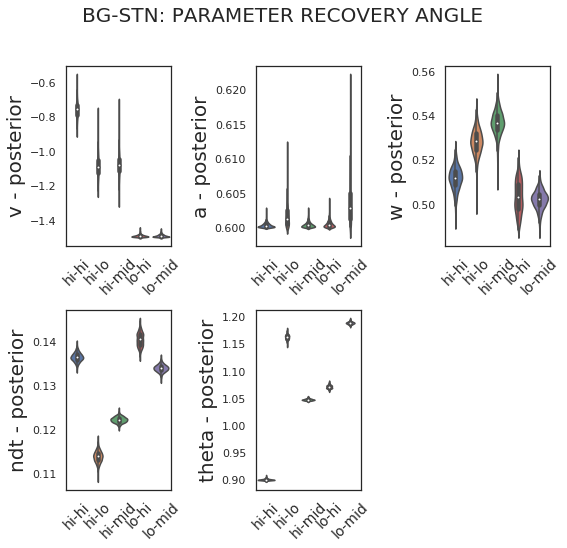

In [61]:
bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'theta'],
                   title = 'BG-STN: PARAMETER RECOVERY ANGLE',
                   x_labels = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'],
                   data = posterior_samples_arr)

# ['hiconf_go_stnhi.txt',
# 'hiconf_go_stnlo.txt',
# 'hiconf_go_stnmid.txt',
# 'loconf7_go_stnhi.txt',
# 'loconf7_go_stnlo.txt',
# 'loconf7_go_stnmid.txt']

In [67]:
# Plot bound
# Mean posterior predictives
def bgn_boundary_posterior_plot(ax_titles = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'], 
                                 title = 'BG-STN: Bound Posterior',
                                 posterior_parameters = [],
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'bg_posterior_bounds',
                                 n_post_params = 500,
                                 max_t = 2,
                                 show = True):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sub_idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params)
    posterior_parameters = posterior_parameters[:, sub_idx, :]
    
    # Temporary: reverse slope and reverse w
#     posterior_parameters[:, :, 0] = (- 1) * posterior_parameters[:, :, 0]
#     posterior_parameters[:, :, 2] = (1 - posterior_parameters[:, :, 2])
    
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (8, 8), 
                           sharex = False, 
                           sharey = False)
    my_suptitle = fig.suptitle(title + model, fontsize = 24)
    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)
        t_s = np.arange(0, max_t, 0.01)
        for j in range(n_post_params):
            if model == 'weibull_cdf':
                b = posterior_parameters[i, idx[i], 2] * bf.weibull_cdf(t = t_s, 
                                                                        alpha = posterior_parameters[i, idx[j], 4],
                                                                        beta = posterior_parameters[i, idx[j], 5])
            if model == 'angle':
                b = np.maximum(posterior_parameters[i, idx[i], 2] + bf.angle(t = t_s, 
                                                                             theta = posterior_parameters[i, idx[j], 4]), 0)
            
            start_point_tmp = - posterior_parameters[i, idx[j], 1] + \
                              (2 * posterior_parameters[i, idx[j], 1] * posterior_parameters[i, idx[j], 2])
            slope_tmp = posterior_parameters[i, idx[j], 0]
            
            ax[row_tmp, col_tmp].plot(t_s + posterior_parameters[i, idx[j], 3], b, 'black', t_s + posterior_parameters[i, idx[j], 3], -b, 'black', alpha = 0.05)
            ax[row_tmp, col_tmp].plot(t_s + posterior_parameters[i, idx[j], 3], start_point_tmp + slope_tmp * t_s, 'red', alpha = 0.05)
            ax[row_tmp, col_tmp].set_xlim(0, max_t)
            ax[row_tmp, col_tmp].set_ylim(-0.75, 0.75)
        print('passed through')
        
        #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_ylabel('', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    plt.savefig(os.getcwd() + '/figures/' + figure_name + model,
                dpi = 150, 
                transparent = False,
                bbox_inches = 'tight',
                bbox_extra_artists = [my_suptitle])
    if show:
        return plt.show()

passed through
passed through
passed through
passed through
passed through


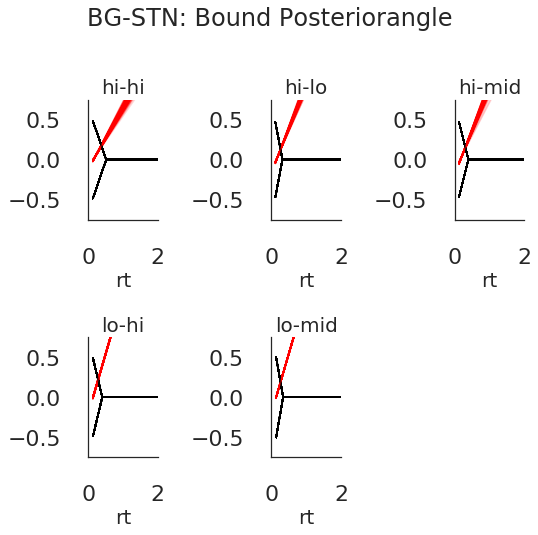

In [68]:
bgn_boundary_posterior_plot(ax_titles = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'], 
                                 title = 'BG-STN: Bound Posterior ',
                                 posterior_parameters = posterior_samples_arr,
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'bg_stn_cnn_posterior_bounds',
                                 n_post_params = 500,
                                 max_t = 2,
                                 show = True)

In [15]:
# Posterior Predictive Plot
def bgn_posterior_predictive_plot(ax_titles = ['hiconf_go_stnhi.txt',
                                               'hiconf_go_stnlo.txt',
                                               'hiconf_go_stnmid.txt',
                                               'loconf7_go_stnhi.txt',
                                               'loconf7_go_stnlo.txt',
                                               'loconf7_go_stnmid.txt'], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = [],
                                 data = [],
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'bg_posterior_predictive',
                                 n_post_params = 200,
                                 samples_by_param = 10,
                                 show = False):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)
    sns.despine(right = True)

    for i in range(data.shape[0]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        tmp = np.zeros((n_post_params*samples_by_param, 2))
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)

        # Run Model simulations
        for j in range(n_post_params):
            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_parameters[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_parameters[i, idx[j], 4],
                                                           'beta': posterior_parameters[i, idx[j], 5]})
            
            tmp[(10*j):(10*(j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        print('passed through')
            
        sns.distplot(tmp[:, 0] * tmp[:, 1], 
                     bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 0.2, 'color': 'blue', 'density': 1},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(bg_data[0][0][:, 0] * bg_data[0][0][:, 1], 
                     hist_kws = {'alpha': 0.2, 'color': 'green', 'density': 1}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('density', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(data.shape[0], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

In [11]:
bg_data = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))
bg_dat = []

# TEMPORARY
for i in range(5):
    if i == 4:
        pass
    bg_dat.append(bg_data[0][i])
bg_dat = np.array(bg_dat)

passed through
passed through
passed through
passed through
passed through


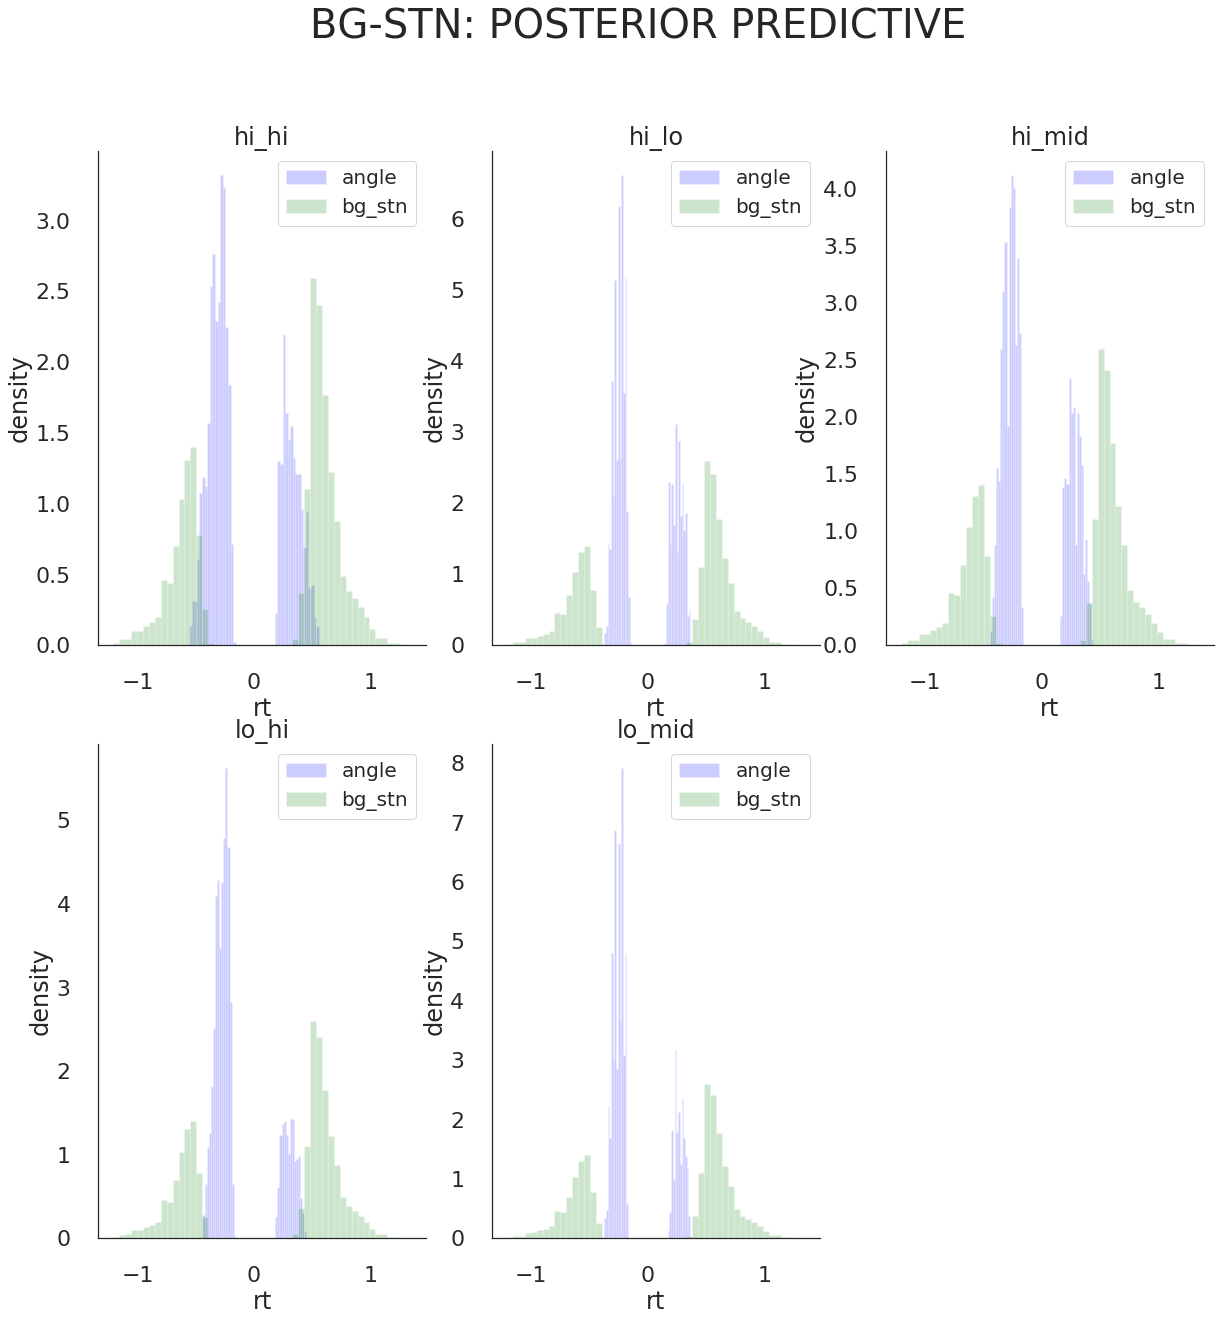

In [22]:
bgn_posterior_predictive_plot(ax_titles =['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_mid'],
                              title = 'BG-STN: POSTERIOR PREDICTIVE',
                              x_labels = [],
                              posterior_parameters = posterior_samples_arr,
                              data = bg_dat,
                              cols = 3,
                              model = 'angle',
                              figure_name = 'bg_posterior_predictive',
                              n_post_params = 200,
                              samples_by_param = 10,
                              show = True)